In [1]:
# Importing python libraries
#
import pandas as pd
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style = 'darkgrid')
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz 
from IPython.display import Image  
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
train_data = pd.read_csv('../notebook/cleaned_train_data.csv')
test_data = pd.read_csv('../notebook/cleaned_test_data.csv')

* **control Number is the id of each participant. Therefore control Number will be dropped**


In [3]:
def drop_column(column_name, data):
    dropped_data = data.drop([column_name], axis = 1) 
    return dropped_data

### Dropping the control number column

In [4]:
train_control_no = train_data.control_number
train_data = drop_column('control_number',train_data)
test_control_no = test_data.control_number
test_data = drop_column('control_number',test_data)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19372 entries, 0 to 19371
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   19372 non-null  int64  
 1   donated                      19372 non-null  int64  
 2   months_since_origin          19372 non-null  int64  
 3   donor_age                    19372 non-null  float64
 4   in_house                     19372 non-null  int64  
 5   urbanicity                   19372 non-null  object 
 6   ses                          19372 non-null  int64  
 7   cluster_code                 19372 non-null  int64  
 8   home_owner                   19372 non-null  object 
 9   donor_gender                 19372 non-null  object 
 10  income_group                 19372 non-null  float64
 11  published_phone              19372 non-null  int64  
 12  overlay_source               19372 non-null  object 
 13  mor_hit_rate    

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   2148 non-null   int64  
 1   months_since_origin          2148 non-null   int64  
 2   donor_age                    2148 non-null   float64
 3   in_house                     2148 non-null   int64  
 4   urbanicity                   2148 non-null   object 
 5   ses                          2148 non-null   int64  
 6   cluster_code                 2148 non-null   int64  
 7   home_owner                   2148 non-null   object 
 8   donor_gender                 2148 non-null   object 
 9   income_group                 2148 non-null   float64
 10  published_phone              2148 non-null   int64  
 11  overlay_source               2148 non-null   object 
 12  mor_hit_rate                 2148 non-null   int64  
 13  wealth_rating     

In [7]:
train_data.head()

,Unnamed: 0,donated,months_since_origin,donor_age,in_house,urbanicity,ses,cluster_code,home_owner,donor_gender,...,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,last_gift_amt,card_prom_12,number_prom_12,months_since_last_gift,months_since_first_gift,file_avg_gift,file_card_gift
0,0,0,101,87.0,0,X,5,54,H,M,...,15.0,20.0,5.0,15.0,5,12,26,92,8.49,7
1,1,1,137,79.0,0,R,2,45,H,M,...,20.0,25.0,5.0,17.0,7,21,7,122,14.72,12
2,2,0,113,75.0,0,S,1,11,H,F,...,23.0,28.0,5.0,19.0,11,32,6,105,16.75,16
3,3,0,92,60.0,0,U,2,4,H,F,...,14.0,17.0,3.0,15.0,11,33,6,92,11.76,12
4,4,0,101,74.0,0,R,2,49,U,F,...,20.0,25.0,5.0,25.0,6,19,18,92,8.83,3


In [8]:
train_data.drop("Unnamed: 0", axis=1, inplace=True)
test_data.drop("Unnamed: 0", axis=1, inplace=True)

In [9]:
train_data.head()

,donated,months_since_origin,donor_age,in_house,urbanicity,ses,cluster_code,home_owner,donor_gender,income_group,...,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,last_gift_amt,card_prom_12,number_prom_12,months_since_last_gift,months_since_first_gift,file_avg_gift,file_card_gift
0,0,101,87.0,0,X,5,54,H,M,2.0,...,15.0,20.0,5.0,15.0,5,12,26,92,8.49,7
1,1,137,79.0,0,R,2,45,H,M,7.0,...,20.0,25.0,5.0,17.0,7,21,7,122,14.72,12
2,0,113,75.0,0,S,1,11,H,F,5.0,...,23.0,28.0,5.0,19.0,11,32,6,105,16.75,16
3,0,92,60.0,0,U,2,4,H,F,6.0,...,14.0,17.0,3.0,15.0,11,33,6,92,11.76,12
4,0,101,74.0,0,R,2,49,U,F,2.0,...,20.0,25.0,5.0,25.0,6,19,18,92,8.83,3


In [10]:
test_data.head()

,months_since_origin,donor_age,in_house,urbanicity,ses,cluster_code,home_owner,donor_gender,income_group,published_phone,...,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,last_gift_amt,card_prom_12,number_prom_12,months_since_last_gift,months_since_first_gift,file_avg_gift,file_card_gift
0,101,59.0,0,R,2,46,U,F,5.0,0,...,16.0,21.0,5.0,21.0,4,10,26,90,14.71,2
1,137,59.0,0,R,2,43,U,F,5.0,1,...,9.0,11.0,2.0,10.0,9,22,22,129,6.00,14
2,17,30.0,0,T,1,35,H,M,6.0,1,...,15.0,20.0,5.0,20.0,5,14,20,87,8.44,1
3,137,75.0,0,U,1,2,H,M,6.0,1,...,5.0,10.0,5.0,10.0,10,24,19,129,6.50,22
4,5,59.0,0,T,2,40,U,F,2.0,0,...,7.0,10.0,3.0,5.0,5,12,18,85,5.83,2


In [11]:
train_data.shape, test_data.shape

((19372, 48), (2148, 47))

### Undersampling the whole dataset sometimes causes information leakage, I will be undersampling only the training data

In [12]:
donated = train_data[train_data['donated']==1]
not_donated = train_data[train_data['donated']==0]
donor_count = train_data['donated'].value_counts()[1]
random_selection = not_donated.sample(donor_count)
train_data_under_sampled = pd.concat([donated, random_selection])

In [13]:
train_data_under_sampled.shape

(9686, 48)

In [14]:
train_data_under_sampled['donated'].value_counts()

1    4843
0    4843
Name: donated, dtype: int64

In [16]:
# Selecting the independent variables and the target variable
#
y = train_data['donated']
X = train_data.drop('donated', axis = 1)


* **Joining the Train and Test data to encode the categorical columns together**

In [17]:
total_data = pd.concat([X, test_data])

In [18]:

total_data=pd.get_dummies(total_data,drop_first=True)

In [19]:
total_data.head()

,months_since_origin,donor_age,in_house,ses,cluster_code,income_group,published_phone,mor_hit_rate,wealth_rating,median_home_value,...,home_owner_U,donor_gender_M,donor_gender_U,overlay_source_M,overlay_source_P,recency_status_96nk_E,recency_status_96nk_F,recency_status_96nk_L,recency_status_96nk_N,recency_status_96nk_S
0,101,87.0,0,5,54,2.0,0,0,5.0,554,...,0,1,0,0,1,0,0,0,0,0
1,137,79.0,0,2,45,7.0,0,0,3.0,334,...,0,1,0,0,1,0,0,0,0,1
2,113,75.0,0,1,11,5.0,0,0,9.0,2388,...,0,0,0,0,1,0,0,0,0,1
3,92,60.0,0,2,4,6.0,1,0,4.0,1688,...,0,0,0,0,0,0,0,0,0,0
4,101,74.0,0,2,49,2.0,1,8,5.0,514,...,1,0,0,0,0,0,0,0,0,0


In [20]:
# categorical_columns = []
# for col in total_data.columns:
    # unique_column =total_data[col].nunique()
    # if unique_column <=60:
        # categorical_columns.append(col)

In [21]:
# print(categorical_columns)

In [22]:
# from sklearn.preprocessing import LabelEncoder
# le=LabelEncoder()
# for i in list(categorical_columns):
        # total_data[i]=le.fit_transform(total_data[i])

* **Splitting the Train and Test data to after encoding the categorical columns**

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_d1 = scaler.fit_transform(total_data)
train_d2 = pd.DataFrame(train_d1,columns=total_data.columns)
total_data = train_d2

In [24]:
X_train_cat_encoded =  total_data.iloc[:19372]
X_test_cat_encoded =  total_data.iloc[19372:]
X_train_cat_encoded.shape, X_test_cat_encoded.shape

((19372, 57), (2148, 57))

In [25]:
total_data.head()

,months_since_origin,donor_age,in_house,ses,cluster_code,income_group,published_phone,mor_hit_rate,wealth_rating,median_home_value,...,home_owner_U,donor_gender_M,donor_gender_U,overlay_source_M,overlay_source_P,recency_status_96nk_E,recency_status_96nk_F,recency_status_96nk_L,recency_status_96nk_N,recency_status_96nk_S
0,0.727273,1.000000,0.0,1.00,1.000000,0.166667,0.0,0.000000,0.555556,0.092333,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.905882,0.0,0.25,0.830189,1.000000,0.0,0.000000,0.333333,0.055667,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.818182,0.858824,0.0,0.00,0.188679,0.666667,0.0,0.000000,1.000000,0.398000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.659091,0.682353,0.0,0.25,0.056604,0.833333,1.0,0.000000,0.444444,0.281333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.727273,0.847059,0.0,0.25,0.905660,0.166667,1.0,0.033195,0.555556,0.085667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X_train_cat_encoded, y, test_size = 0.3, random_state = 0)

In [27]:

# define and configure the model
model = KNeighborsClassifier()
# fit the model
model.fit(X_train, y_train)
# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.7032002752924983
The accuracy score is: 0.7032002752924983 and the f1 score is 0.18976045091592295


              precision    recall  f1-score   support

           0       0.75      0.90      0.82      4336
           1       0.31      0.14      0.19      1476

    accuracy                           0.70      5812
   macro avg       0.53      0.52      0.50      5812
weighted avg       0.64      0.70      0.66      5812



array([[3885,  451],
       [1274,  202]], dtype=int64)

In [28]:

# define and configure the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train, y_train)
# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.6347212663454921
The accuracy score is: 0.6347212663454921 and the f1 score is 0.2859064917591658


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      4336
           1       0.28      0.29      0.29      1476

    accuracy                           0.63      5812
   macro avg       0.52      0.52      0.52      5812
weighted avg       0.64      0.63      0.64      5812



array([[3264, 1072],
       [1051,  425]], dtype=int64)

In [29]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


,importance
feature,
per_capita_income,0.0592
median_home_value,0.0534
median_household_income,0.0497
donor_age,0.0430
pct_attribute4,0.0426
pct_attribute2,0.0426
pct_owner_occupied,0.0396
pct_attribute3,0.0345
lifetime_gift_amount,0.0340


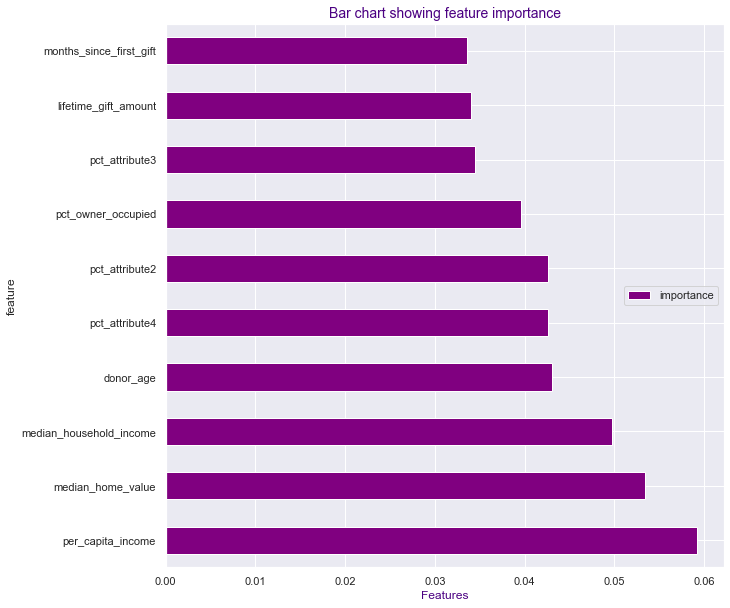

In [30]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [31]:

# define and configure the model
model = XGBClassifier(random_state=43)
# fit the model
model.fit(X_train, y_train)
# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)

[18:06:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy :  0.7241913282863042
The accuracy score is: 0.7241913282863042 and the f1 score is 0.16379760041731872


              precision    recall  f1-score   support

           0       0.75      0.93      0.83      4336
           1       0.36      0.11      0.16      1476

    accuracy                           0.72      5812
   macro avg       0.56      0.52      0.50      5812
weighted avg       0.65      0.72      0.66      5812



array([[4052,  284],
       [1319,  157]], dtype=int64)

In [32]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


,importance
feature,
frequency_status_97nk,0.0789
recency_status_96nk_E,0.0327
last_gift_amt,0.0243
recency_status_96nk_L,0.0242
file_card_gift,0.0224
card_prom_12,0.0214
pep_star,0.0210
urbanicity_R,0.0207
recency_status_96nk_S,0.0207


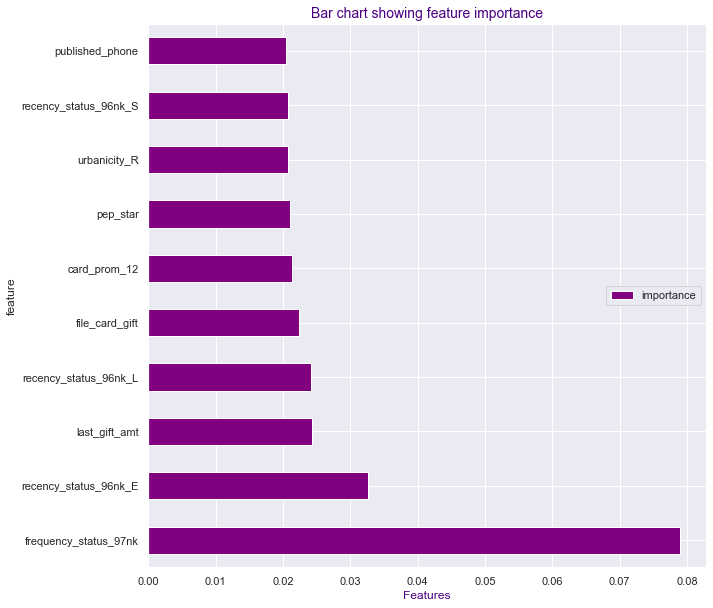

In [33]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [34]:
# define and configure the model
model = CatBoostClassifier(verbose=False)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.7465588437715073
The accuracy score is: 0.7465588437715073 and the f1 score is 0.09908256880733944


              precision    recall  f1-score   support

           0       0.75      0.98      0.85      4336
           1       0.51      0.05      0.10      1476

    accuracy                           0.75      5812
   macro avg       0.63      0.52      0.48      5812
weighted avg       0.69      0.75      0.66      5812



array([[4258,   78],
       [1395,   81]], dtype=int64)

In [35]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df



,importance
feature,
median_home_value,5.5150
donor_age,5.3404
pct_owner_occupied,5.3313
median_household_income,4.5139
pct_attribute4,4.1972
per_capita_income,4.0181
pct_attribute2,3.8243
pct_attribute3,3.5997
cluster_code,3.2404


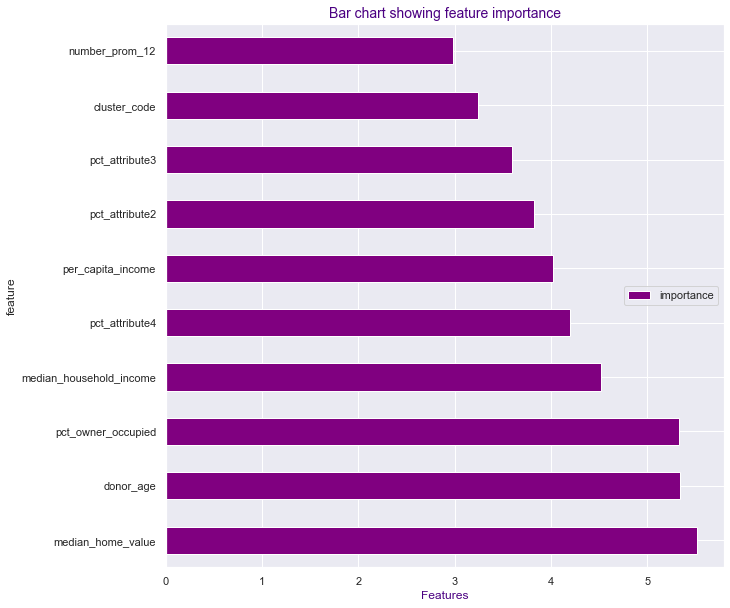

In [36]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [37]:

# define and configure the model
# l1 regularization gives better results
model = LogisticRegression(penalty='l2', C=10, random_state = 0)
# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)

Accuracy :  0.7460426703372333
The accuracy score is: 0.7460426703372333 and the f1 score is 0.030223390275952694


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      4336
           1       0.50      0.02      0.03      1476

    accuracy                           0.75      5812
   macro avg       0.62      0.51      0.44      5812
weighted avg       0.69      0.75      0.64      5812



array([[4313,   23],
       [1453,   23]], dtype=int64)

In [38]:
# define and configure the model
model = AdaBoostClassifier(random_state = 0)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.7463867859600826
The accuracy score is: 0.7463867859600826 and the f1 score is 0.07990012484394507


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      4336
           1       0.51      0.04      0.08      1476

    accuracy                           0.75      5812
   macro avg       0.63      0.51      0.47      5812
weighted avg       0.69      0.75      0.66      5812



array([[4274,   62],
       [1412,   64]], dtype=int64)

In [39]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


,importance
feature,
recent_avg_card_gift_amt,0.10
donor_age,0.10
median_home_value,0.08
frequency_status_97nk,0.06
last_gift_amt,0.06
pct_owner_occupied,0.06
recent_star_status,0.04
lifetime_max_gift_amt,0.04
per_capita_income,0.04


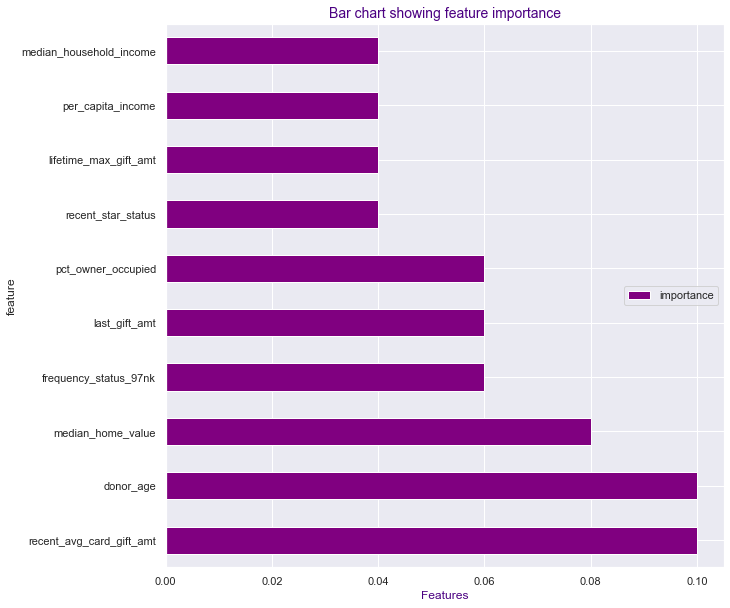

In [40]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = False)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [41]:
# define and configure the model
model = RandomForestClassifier(random_state = 0)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.7455264969029594
The accuracy score is: 0.7455264969029594 and the f1 score is 0.06922592825676527


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      4336
           1       0.49      0.04      0.07      1476

    accuracy                           0.75      5812
   macro avg       0.62      0.51      0.46      5812
weighted avg       0.68      0.75      0.65      5812



array([[4278,   58],
       [1421,   55]], dtype=int64)

In [42]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


,importance
feature,
median_home_value,0.0447
per_capita_income,0.0411
median_household_income,0.0396
pct_attribute3,0.0350
pct_owner_occupied,0.0350
pct_attribute4,0.0349
pct_attribute2,0.0341
donor_age,0.0337
lifetime_avg_gift_amt,0.0322


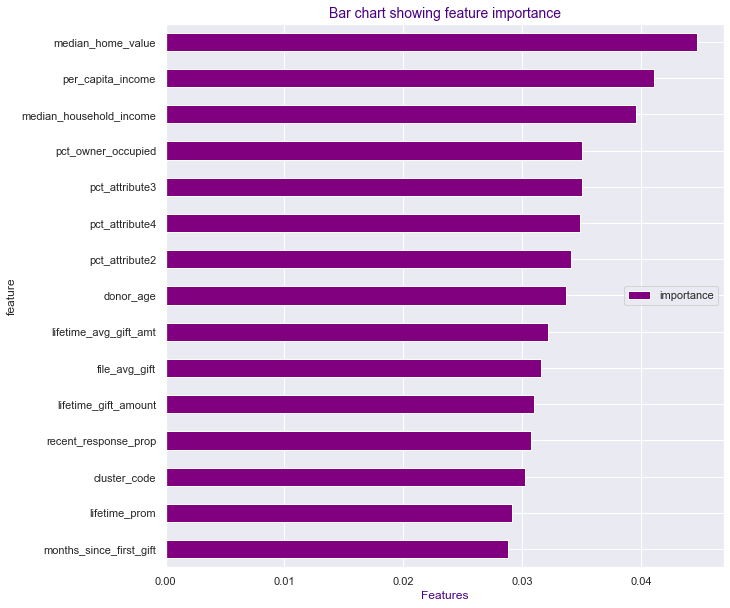

In [43]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:15].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [44]:
impo_df.index

Index(['months_since_first_gift', 'lifetime_prom', 'cluster_code',
       'recent_response_prop', 'lifetime_gift_amount', 'file_avg_gift',
       'lifetime_avg_gift_amt', 'donor_age', 'pct_attribute2',
       'pct_attribute4', 'pct_attribute3', 'pct_owner_occupied',
       'median_household_income', 'per_capita_income', 'median_home_value'],
      dtype='object', name='feature')

# Data Modelling

## RandomForest Classifier

### Remodelling with the most important features only

In [45]:
# Selecting only important features and the y variable
#
X = X[impo_df.index]

y = y


In [46]:
X.shape, y.shape

((19372, 15), (19372,))

In [47]:
# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# define and configure the model
model = RandomForestClassifier(random_state = 0)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.7431176875430144
The accuracy score is: 0.7431176875430144 and the f1 score is 0.056854074542008845


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      4336
           1       0.42      0.03      0.06      1476

    accuracy                           0.74      5812
   macro avg       0.58      0.51      0.45      5812
weighted avg       0.67      0.74      0.65      5812



array([[4274,   62],
       [1431,   45]], dtype=int64)

In [48]:
# Selecting the independent variables and the target variable
#
y = train_data_under_sampled['donated']
X = train_data_under_sampled.drop('donated', axis = 1)


* **Joining the Train and Test data to encode the categorical columns together**

In [49]:
total_data = pd.concat([X, test_data])

In [50]:

total_data=pd.get_dummies(total_data,drop_first=True)

In [51]:
total_data.head()

,months_since_origin,donor_age,in_house,ses,cluster_code,income_group,published_phone,mor_hit_rate,wealth_rating,median_home_value,...,home_owner_U,donor_gender_M,donor_gender_U,overlay_source_M,overlay_source_P,recency_status_96nk_E,recency_status_96nk_F,recency_status_96nk_L,recency_status_96nk_N,recency_status_96nk_S
1,137,79.0,0,2,45,7.0,0,0,3.0,334,...,0,1,0,0,1,0,0,0,0,1
7,89,79.0,0,2,28,1.0,0,0,5.0,1004,...,0,0,0,0,1,0,0,0,0,0
9,101,63.0,0,2,43,4.0,1,0,5.0,399,...,0,0,0,0,0,0,0,0,0,1
14,137,60.0,0,2,43,5.0,1,0,1.0,475,...,1,0,0,1,0,0,0,0,0,1
16,77,81.0,0,2,45,4.0,1,24,3.0,530,...,1,1,0,0,0,0,0,0,0,0


In [52]:
total_data.shape

(11834, 57)

In [53]:
# categorical_columns = []
# for col in total_data.columns:
    # unique_column =total_data[col].nunique()
    # if unique_column <=60:
        # categorical_columns.append(col)

In [54]:
# print(categorical_columns)

In [55]:
# from sklearn.preprocessing import LabelEncoder
# le=LabelEncoder()
# for i in list(categorical_columns):
        # total_data[i]=le.fit_transform(total_data[i])

* **Splitting the Train and Test data to after encoding the categorical columns**

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_d1 = scaler.fit_transform(total_data)
train_d2 = pd.DataFrame(train_d1,columns=total_data.columns)
total_data = train_d2

In [57]:
X_train_cat_encoded =  total_data.iloc[:9686]
X_test_cat_encoded =  total_data.iloc[9686:]
X_train_cat_encoded.shape, X_test_cat_encoded.shape

((9686, 57), (2148, 57))

In [58]:
total_data.head()

,months_since_origin,donor_age,in_house,ses,cluster_code,income_group,published_phone,mor_hit_rate,wealth_rating,median_home_value,...,home_owner_U,donor_gender_M,donor_gender_U,overlay_source_M,overlay_source_P,recency_status_96nk_E,recency_status_96nk_F,recency_status_96nk_L,recency_status_96nk_N,recency_status_96nk_S
0,1.000000,0.905882,0.0,0.25,0.830189,1.000000,0.0,0.0,0.333333,0.055667,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.636364,0.905882,0.0,0.25,0.509434,0.000000,0.0,0.0,0.555556,0.167333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.727273,0.717647,0.0,0.25,0.792453,0.500000,1.0,0.0,0.555556,0.066500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.000000,0.682353,0.0,0.25,0.792453,0.666667,1.0,0.0,0.111111,0.079167,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.545455,0.929412,0.0,0.25,0.830189,0.500000,1.0,0.1,0.333333,0.088333,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X_train_cat_encoded, y, test_size = 0.3, random_state = 0)

In [41]:
# define and configure the model
model = RandomForestClassifier(random_state = 0)

# fit the model
model.fit(X_train, y_train)

# evaluate the model
preds = model.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, preds))

print(f'The accuracy score is: {accuracy_score(y_test, preds)} and the f1 score is {f1_score(y_test, preds)}')
print('\n')
print(f'{classification_report(y_test, preds)}')
confusion_matrix(y_test, preds)


Accuracy :  0.7455264969029594
The accuracy score is: 0.7455264969029594 and the f1 score is 0.06922592825676527


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      4336
           1       0.49      0.04      0.07      1476

    accuracy                           0.75      5812
   macro avg       0.62      0.51      0.46      5812
weighted avg       0.68      0.75      0.65      5812



array([[4278,   58],
       [1421,   55]], dtype=int64)

In [42]:
# Checking for the most important features that contribute most in predicting the target
# Creating a dataframe of features and their respective importances
#
impo_df = pd.DataFrame({'feature': X_train_cat_encoded.columns, 'importance': np.round(model.feature_importances_, 4)}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df


,importance
feature,
median_home_value,0.0447
per_capita_income,0.0411
median_household_income,0.0396
pct_attribute3,0.0350
pct_owner_occupied,0.0350
pct_attribute4,0.0349
pct_attribute2,0.0341
donor_age,0.0337
lifetime_avg_gift_amt,0.0322


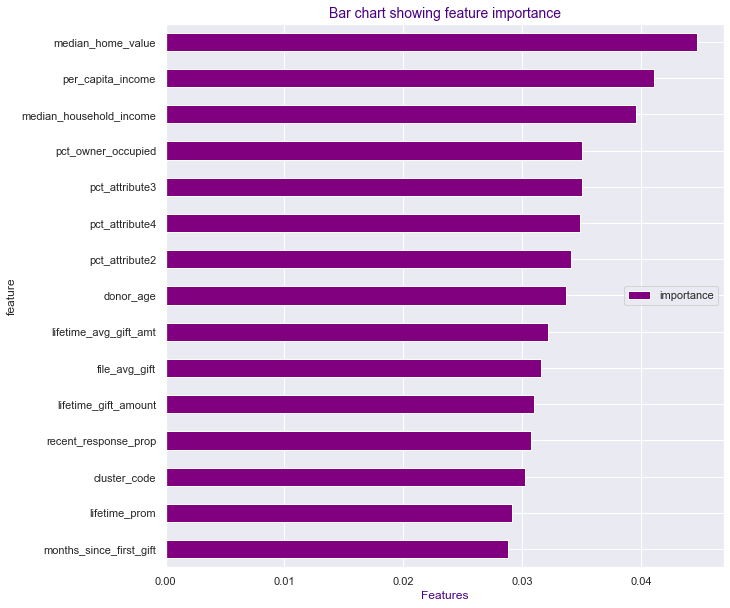

In [43]:
# Creating a bar chart of feature importance in descending order
#
impo_df = impo_df[:15].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [44]:
impo_df.index

Index(['months_since_first_gift', 'lifetime_prom', 'cluster_code',
       'recent_response_prop', 'lifetime_gift_amount', 'file_avg_gift',
       'lifetime_avg_gift_amt', 'donor_age', 'pct_attribute2',
       'pct_attribute4', 'pct_attribute3', 'pct_owner_occupied',
       'median_household_income', 'per_capita_income', 'median_home_value'],
      dtype='object', name='feature')

### Parameter Tuning

In [60]:
# Previewing the parameters to tune
#
RandomForestClassifier()

RandomForestClassifier()

In [ ]:
# Creating a dictionary of parameters to tune
#
params = {'n_estimators': [10, 20, 30, 50, 100],
         'max_depth': [1, 2, 3, 4, 5]}

# Setting the number of folds to 10 and instantiating the model
# 
kfold = KFold(n_splits=10, shuffle=True)
model = RandomForestClassifier()

search = GridSearchCV(model, param_grid=params, scoring = 'f1', cv = kfold)

# Fitting the grid search with the X and the y variables
#
search.fit(X_train_cat_encoded, y)

# Checking for the best parameters
#
print(f'The best parameters are: {search.best_params_}')

In [ ]:
# Applying the best parameters to the model


# Splitting the data into training and testing sets
#
X_train, X_test, y_train, y_test = train_test_split(X_train_cat_encoded, y, test_size = 0.3, random_state = 0)

# Instantiating the model
#
rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state = 0)
rf.fit(X_train, y_train)

# Making predictions
#
y_pred = rf.predict(X_test)

# Measuring the accuracy of the model
#
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)} and the f1 score is {f1_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')
confusion_matrix(y_test, y_pred)

*Parameter tuning hasn't decreased or increased the f1 score*

### Cross Validation to check for the stability of the model

In [ ]:
# Performing cross validation of ten folds
#
scores = cross_val_score(rf, X_train_cat_encoded, y, scoring = 'f1', cv = 10)

# Calculating the mean of the cross validation scores
#
print(f'Mean of cross validation scores is {scores.mean()}')

# Calculating the variance of the cross validation scores from the mean
#
print(f'Standard deviation of the cross validation scores is {scores.std()}')

## Challenging the solution

*Using different models to check whether performance can be improved*

In [ ]:
y__ =  y.copy()
total_test_set_prediction = []
kf = KFold(n_splits=5, random_state=False, shuffle=False)
for train_index, test_index in kf.split(X_train_cat_encoded):
    X_train, X_test = X_train_cat_encoded.iloc[train_index], X_train_cat_encoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_model = RandomForestClassifier(n_estimators=600,random_state=0)

    # fit the model
    rf_model.fit(X_train, y_train)
    # evaluate the model
    preds = rf_model.predict(X_test)
    test_preds  = rf_model.predict(X_test_cat_encoded)
    total_test_set_prediction.append(test_preds)
    #arr = np.stack([arr,test_preds],1)
    y__.iloc[test_index] = preds
    print('k-fold Accuracy : ',accuracy_score(y_test, preds))
print('Cross_validation_Accuracy : ',accuracy_score(y__, y))
test_pred_array = np.array(total_test_set_prediction)
test_pred_array_T = test_pred_array.transpose()
final_test_pred  = mode(test_pred_array_T,1)[0]
final_test_pred = final_test_pred.reshape((-1))


In [ ]:
predicted_donors = pd.DataFrame()
predicted_donors['donated'] = final_test_pred
predicted_donors['control_no'] = test_control_no
predicted_donors.head()

In [ ]:
predicted_donors['donated'].value_counts()

## Conclusion

* *Out of all the models used to predict whether a person has donates or not, the RandomForestClassifier performs well with an accuracy score of approximately 74.6%*



